# **KNN based Collaborate Filtering**

## **Objective**
Build an item-based recommender system for movie recommendation based on the [MovieLens](https://grouplens.org/datasets/movielens/latest/) Datasets.
The KNN based collaborate filtering algorithm will be implemented in the system.

In [93]:
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import sklearn
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## **Load Data**

The ml-latest dataset can be downloaded [Here](https://grouplens.org/datasets/movielens/latest/), and just load the movies.csv and ratings.csv file. Combine these two files, we are able to get the movie info and the corresponding rating score.

In [14]:
from google.colab import files
files.upload()
files.upload()

Saving ratings.csv to ratings.csv


Saving movies.csv to movies.csv


{'movies.csv': b'movieId,title,genres\r\n1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy\r\n2,Jumanji (1995),Adventure|Children|Fantasy\r\n3,Grumpier Old Men (1995),Comedy|Romance\r\n4,Waiting to Exhale (1995),Comedy|Drama|Romance\r\n5,Father of the Bride Part II (1995),Comedy\r\n6,Heat (1995),Action|Crime|Thriller\r\n7,Sabrina (1995),Comedy|Romance\r\n8,Tom and Huck (1995),Adventure|Children\r\n9,Sudden Death (1995),Action\r\n10,GoldenEye (1995),Action|Adventure|Thriller\r\n11,"American President, The (1995)",Comedy|Drama|Romance\r\n12,Dracula: Dead and Loving It (1995),Comedy|Horror\r\n13,Balto (1995),Adventure|Animation|Children\r\n14,Nixon (1995),Drama\r\n15,Cutthroat Island (1995),Action|Adventure|Romance\r\n16,Casino (1995),Crime|Drama\r\n17,Sense and Sensibility (1995),Drama|Romance\r\n18,Four Rooms (1995),Comedy\r\n19,Ace Ventura: When Nature Calls (1995),Comedy\r\n20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller\r\n21,Get Shorty (1995),Comedy|Crime|Thril

In [15]:
df_movies = pd.read_csv('movies.csv', usecols=['movieId','title'], 
                        dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv('ratings.csv', usecols=['userId','movieId','rating'], 
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [16]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int32 
 1   title    58098 non-null  object
dtypes: int32(1), object(1)
memory usage: 681.0+ KB


In [17]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 317.6 MB


In [18]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [19]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


Let's see how many unique users and movies in the dataset

In [20]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print("There are {} unique users and {} unique movies in the dataset".format(num_users,num_items))

There are 283228 unique users and 53889 unique movies in the dataset


## **Data Analysis and Clean**
Explore more about the data, e.g. the distributions of users and movies of the dataset. From the distribution of users we can understand how many users are frequently rating different movies. From the distribution of movies we are able to know how many movies are frequently rated by different users. Finally, clean the original dataset by eliminating those unfrequently rated movies and less active users so that the model can be trained properly.

### **Histogram of Ratings**


In [26]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(),columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


Text(0, 0.5, 'Frequency of ratings')

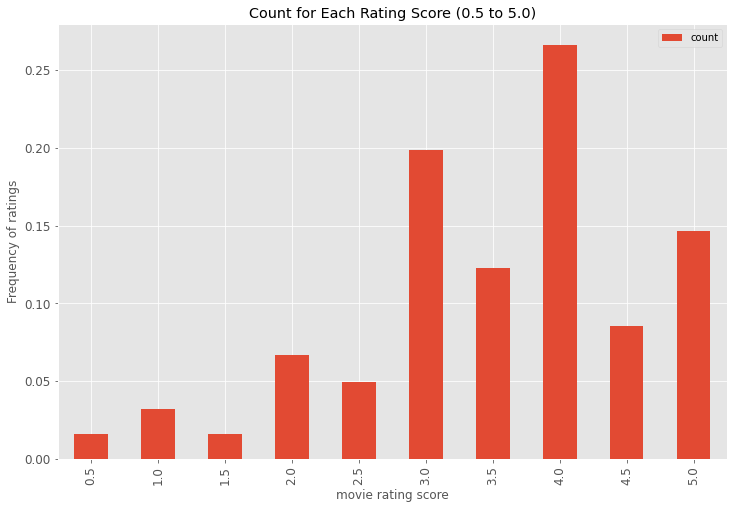

In [32]:
ax = (df_ratings_cnt_tmp['count'] / df_ratings_cnt_tmp['count'].sum()).reset_index().rename(columns={'rating': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (0.5 to 5.0)',
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("Frequency of ratings")

Note that among these rated movies, score 4.0 is the most frequency rating, about 27% movies are rated as 4.0.

In [33]:
valid_rating = df_ratings_cnt_tmp['count'].sum()
total_rating = num_items * num_users
print("There are {} valid ratings, the total number of rating is {}".format(valid_rating,total_rating))

There are 27753444 valid ratings, the total number of rating is 15262873692


From the number of ratings we know that many movies are not get rated by users, or users are not rating every movies. Since the minimum score of rating is 0.5, if the user did not rate that movie, let's use 0 to represent it.

In [36]:
rating_zero_cnt = total_rating-valid_rating
# append counts of zero rating
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count':rating_zero_cnt},index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,15235120248
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


Noticed that the number of 0 rating is too large compare with others. In order to plot them in a same figure, a logarithmic transform can be utilized.

In [40]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,15235120248,23.446869
0.5,442388,12.999943
1.0,886233,13.694735
1.5,441354,12.997603
2.0,1850627,14.431035
2.5,1373419,14.132814
3.0,5515668,15.523103
3.5,3404360,15.040568
4.0,7394710,15.816275
4.5,2373550,14.679897


Text(0, 0.5, 'number of ratings')

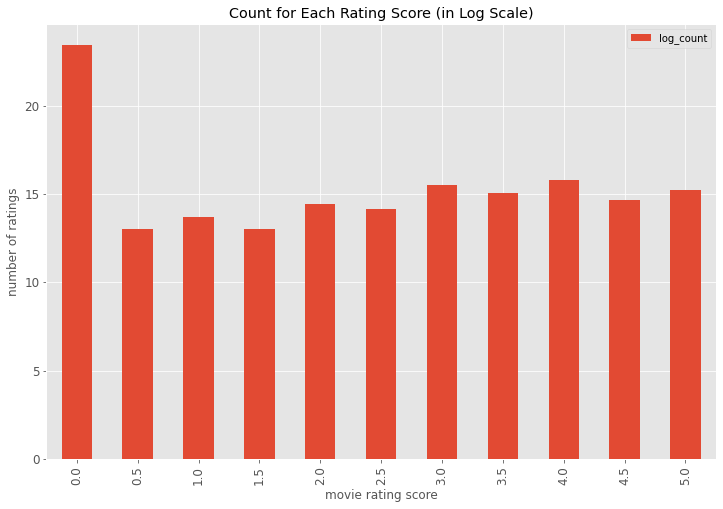

In [42]:
ax = df_ratings_cnt['log_count'].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='log_count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

### **Movie Rating Frequecy Analysis**
Now, explore more on how many movies are rated by users and compare the frequency of rated movies.

In [46]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [51]:
# get rating count of each movie
df_movies_rating_cnt = pd.DataFrame({'count':df_ratings.groupby('movieId').size()},columns=['count'])
df_movies_rating_cnt.head()

,count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


Text(20.20000000000001, 0.5, 'number of ratings')

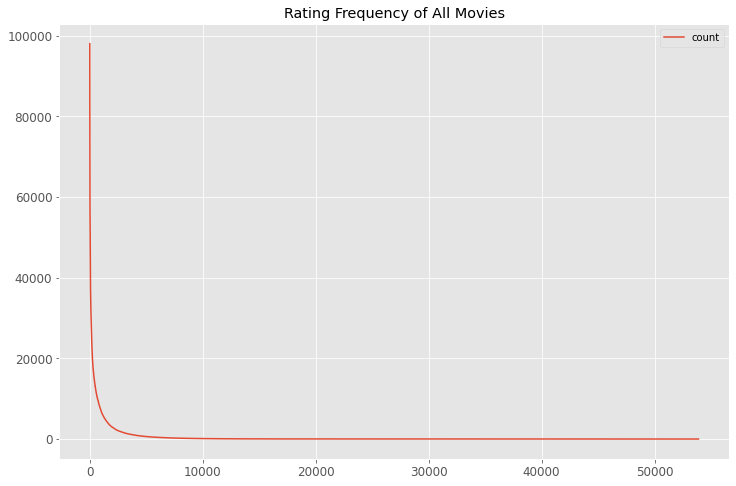

In [52]:
df_movies_rating_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot(
    figsize=(12, 8),
    title='Rating Frequency of All Movies',
    fontsize=12
)
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

This distribution plot is a good example that clearly shows the long-tail property in real-world scenario. Only a small portion of items are frequently rated by the users, those items are recognized as popular item, a vast majority items that are not popular, which will be rarely rated in reality, so that the result distribution is highly skewed.

Text(0, 0.5, 'number of ratings (log scale)')

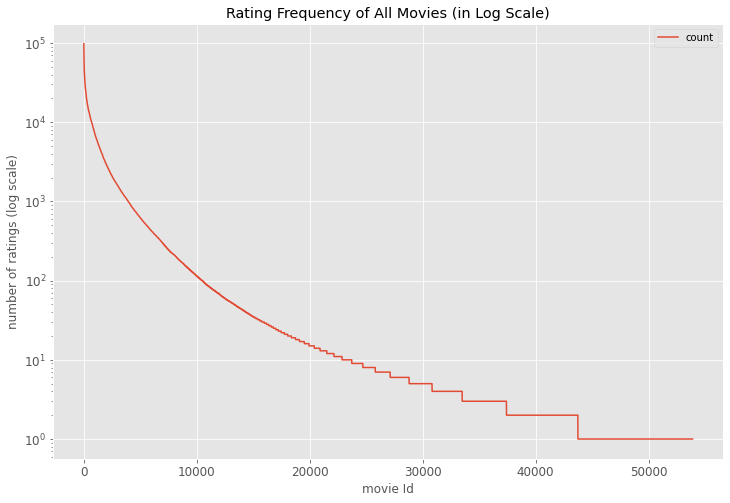

In [48]:
# plot rating frequency of all movies in log scale
ax = df_movies_rating_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

The rating distribution in a log-scale shows that there are nearly 10000 out of 58097 items are rated over 100 times and more than 20000 items are rated less than 10 times.
<br>
Let's see the details by calculating the quantiles of rating count.

In [49]:
df_movies_rating_cnt['count'].quantile(np.arange(1, 0.55, -0.05))

1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
0.60       12.0
Name: count, dtype: float64

From the quantile analysis, the most rated movie has been rated 97999 times, there are 5% movies have been rated more than 1855 times and 20% movies have been rated more than 91 times. Now, threshold the movies that have more than 50 times rating, which gives us the top 25% (53889/4=13472) movies, and we still have a good amount samples for building up the model, also by dropping out the movies that has fewer user watched makes our training data more reliable so that improve the recommendation quality.

In [59]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_rating_cnt.query('count >= @popularity_thres').index))
len(popular_movies)

13360

There are 13360 movies have more than 50 times rating. Then, we drop the movies in the rating table as well.

In [60]:
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping unpopular movies:  (27430748, 3)


Note that, after drop 75% movies, we still keep almost same rating dataset as original rating dataset. Next, we do the same for the users, based on the modified dataset (drop the unpopular movies), drop the user which has fewer rating records to improve the model quality.

### **User activition Analysis**

Expore more on how many users have rated moves and compare the rating

In [62]:
df_ratings_drop_movies.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [63]:
# get user count of each movie
df_user_rating_cnt = pd.DataFrame({'count':df_ratings_drop_movies.groupby('userId').size()},columns=['count'])
df_user_rating_cnt.head()

,count
userId,
1,16
2,15
3,11
4,736
5,72


Text(20.20000000000001, 0.5, 'number of ratings')

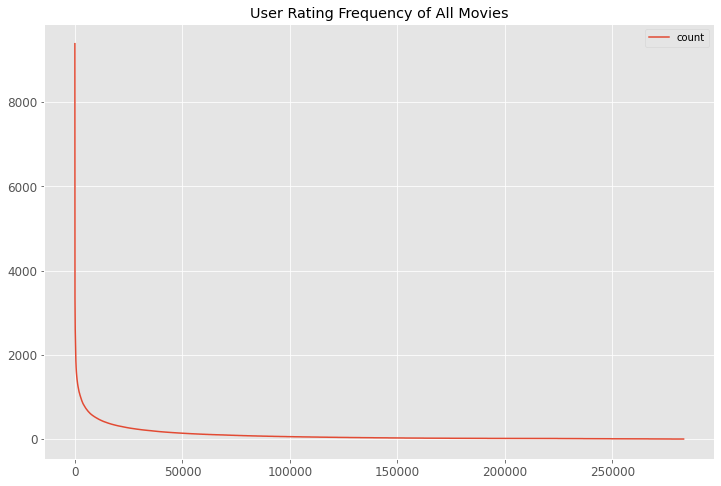

In [64]:
df_user_rating_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot(
    figsize=(12, 8),
    title='User Rating Frequency of All Movies',
    fontsize=12
)
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

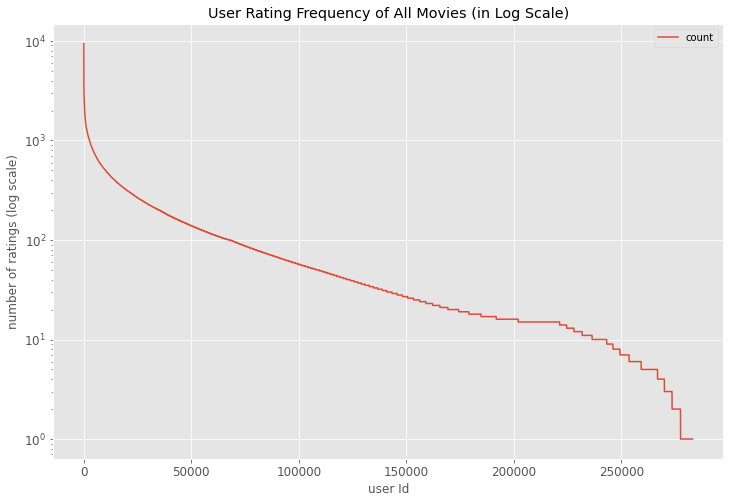

In [65]:
# plot rating frequency of all movies in log scale
ax = df_user_rating_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='User Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings (log scale)")

Same thing happened for the user rating distribution, it is again a long-tail distribution, meaning that only a small amount of user has rated a considerable amount of movies, the majority users only rate few movies or even not rate any movies.

In [66]:
df_user_rating_cnt['count'].quantile(np.arange(1, 0.55, -0.05))

1.00    9384.0
0.95     403.0
0.90     239.0
0.85     164.0
0.80     121.0
0.75      94.0
0.70      73.0
0.65      58.0
0.60      47.0
Name: count, dtype: float64

The most rating user has rated 9384 different movies! 5% users rated more than 403 movies and 25% users rated more than 94 movies. Use the threshold for movie ratings, we keep the users that have rated more than 150 movies, that's about 15% users.

In [67]:
# filter data
popularity_thres = 150
popular_users = list(set(df_user_rating_cnt.query('count >= @popularity_thres').index))
len(popular_users)

46658

In [68]:
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(popular_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping unpopular movies and inactive users:  (18672534, 3)


## **Train KNN model for item-based collaborative filtering**

The original dataset has already been cleaned according to the movies rating frequnecy analysis and user activity analysis. Then a KNN based colaborative filtering model can be built by using the cleaned dataset. 

In [76]:
df_ratings_drop_users.head()

,userId,movieId,rating
42,4,1,4.0
43,4,2,4.0
44,4,5,2.0
45,4,6,4.5
46,4,10,4.0


In [75]:
df_ratings_drop_users.shape

(18672534, 3)

In [77]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [80]:
movie_user_mat[movie_user_mat.columns[:10]].head()

userId,4,14,15,19,42,43,48,51,55,56
movieId,,,,,,,,,,
1,4.0,4.5,4.0,0.0,4.0,5.0,0.0,4.0,5.0,2.5
2,4.0,4.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,3.5
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 97.00% of ratings in our data is missing


Since the dimensionality is pretty high, once we build a KNN model based on a high dimensional dataset, either we should reduce the dimensionality or we should change the metric function, otherwise it will encounter a curse of dimensionality. By default the KNN from scikit-learn package has the metric of minkowski (similar to Euclidean distance when dimention = 2), which should be changed to cosine, the number of neighbor is set to be 20.

In [94]:
sorted(sklearn.neighbors.VALID_METRICS['brute'])

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'haversine',
 'jaccard',
 'kulsinski',
 'l1',
 'l2',
 'mahalanobis',
 'manhattan',
 'matching',
 'minkowski',
 'nan_euclidean',
 'precomputed',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'wminkowski',
 'yule']

In [95]:
%env JOBLIB_TEMP_FOLDER=/tmp # if running out of the shared memory 
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp # if running out of the shared memory


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [96]:
!pip3 install fuzzywuzzy
!pip3 install python-Levenshtein

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144788 sha256=152de303764c4c3a0cc2bd7befd77b8dc8fd923b1a86dc88873215e1967abee4
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


Use the fuzzywuzzy package to find the similarities of movies to a given movie name. For example, input movie Iron Man, it will search the movie dataset and find the most match result.

In [99]:
# utils import
from fuzzywuzzy import fuzz

In [100]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the index of closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort according to the ratio, order by descending order
    match_tuple = sorted(match_tuple, key=lambda x: x[2], reverse=True)
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


Find the similar movies of Iron Man

In [101]:
idx = fuzzy_matching(mapper=movie_to_idx, fav_movie='Iron Man', verbose=True)
idx

Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 2 (2010)', 'Iron Man 3 (2013)']



9295

In [102]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx and distance of recommendations and sort on the distance according to descending order
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1] # drop the first recommendation, since it is the input movie
    # get reverse mapper (movie index to movie title)
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [103]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 2 (2010)', 'Iron Man 3 (2013)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Up (2009), with distance of 0.3350299596786499
2: Sherlock Holmes (2009), with distance of 0.33150821924209595
3: Batman Begins (2005), with distance of 0.2976230978965759
4: Star Trek (2009), with distance of 0.2970428466796875
5: Avengers, The (2012), with distance of 0.2968347668647766
6: Avatar (2009), with distance of 0.29315418004989624
7: Iron Man 2 (2010), with distance of 0.2907562255859375
8: Inception (2010), with distance of 0.2900804877281189
9: WALL·E (2008), with distance of 0.2871159315109253
10: Dark Knight, The (2008), with distance of 0.2037333846092224


## **Summary**

In this project, a KNN based colaborative filtering model is built for item based recommender system. The model will generate recommended movies according to the input movie names. However, there are shortcommings of this item based colaborative filtering. Once the items are new or less rated, the model will not able to give recommandation to them, which meaning that, it is not new item friendly, the recommender system most likely will recommand those popular items. The algorithm can be improved by using a ALS algorithm in the recommender system, which will be showed in next project.